In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("ITC_Stock").getOrCreate()

# Read ITC data from HDFS
df = spark.read.csv("hdfs://localhost:9000/bigdata/itc/ITC_minute.csv", header=True, inferSchema=True)

df.show(5)
df.printSchema()


25/10/15 21:50:51 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
                                                                                

+----------------+------+------+------+------+------+
|            date|  open|  high|   low| close|volume|
+----------------+------+------+------+------+------+
|02-02-2015 09:15| 211.6|212.75|211.55|212.25|152000|
|02-02-2015 09:16| 212.2| 212.3|211.45|211.75| 76319|
|02-02-2015 09:17|211.85|212.25| 211.8|212.15| 42411|
|02-02-2015 09:18| 212.1|212.15|212.05|212.15| 44466|
|02-02-2015 09:19|212.15| 212.5|212.15| 212.5| 90079|
+----------------+------+------+------+------+------+
only showing top 5 rows
root
 |-- date: string (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: integer (nullable = true)



# Feature Engineering

In [2]:
from pyspark.sql.functions import col, to_timestamp

# convert date to proper timestamp
df = df.withColumn("date", to_timestamp(col("date"), "dd-MM-yyyy HH:mm")) \
       .orderBy("date")

print("Done")

Done


In [3]:
pdf = df.select("date", "close").toPandas()
pdf.set_index("date", inplace=True)

print("Done")

Done


In [4]:
# Normalising Data

from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(pdf[['close']])

print("done")

done


In [5]:
# 60 timestamps -> next close (ie) 1 min interval 

def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Reshape for TCN: (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

print("Done")


Done


In [6]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Done, Ready for Training and Test")

Done, Ready for Training and Test


# Model Building

In [7]:
# TCN (Temporal Convolutional Network)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tcn import TCN

model = Sequential([
    TCN(
        nb_filters=64,
        kernel_size=3,
        dilations=[1, 2, 4, 8],
        nb_stacks=3,
        dropout_rate=0.2,
        return_sequences=False,
        input_shape=(X_train.shape[1], 1)
    ),
    Dense(25),
    Dense(1)
])

# Compile and summarize 
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()



2025-10-15 21:51:22.985006: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-15 21:51:23.044118: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-15 21:51:25.535064: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/dhinesh-fedor/.local/lib/python3.13/site-packages/tcn/tcn.py:268: UserWarn

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tcn (TCN)                       │ (None, 64)             │       284,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,131 (1.09 MB)

 Trainable params: 286,131 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Training

history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test),
                    epochs=20, batch_size=64)


Epoch 1/20
12157/12157 ━━━━━━━━━━━━━━━━━━━━ 693s 57ms/step - loss: 7.9389e-06 - val_loss: 2.7081e-04
Epoch 2/20
12157/12157 ━━━━━━━━━━━━━━━━━━━━ 653s 54ms/step - loss: 7.9015e-06 - val_loss: 6.2213e-05
Epoch 3/20
12156/12157 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 5.7627e-06

KeyboardInterrupt: 

In [20]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1,1))

y_test_real = scaler.inverse_transform(y_test.reshape(-1,1))


6079/6079 ━━━━━━━━━━━━━━━━━━━━ 52s 9ms/step


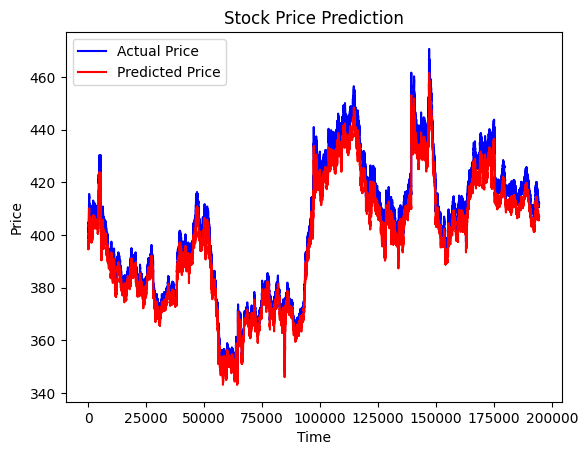

In [21]:
import matplotlib.pyplot as plt

plt.plot(y_test_real, color='blue', label='Actual Price')
plt.plot(predictions, color='red', label='Predicted Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [22]:
# Model Save

# Save the full model (architecture + weights + optimizer state)
model.save('itc_tcn_model.keras')

import pickle

with open('scaler_tcn.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("done")


done


In [23]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import pickle

# ---------------------------
# Load Alpha Vantage Data
# ---------------------------
api_key = "R9SUJLHNB1HWPE3W"
symbol = "ITC.BSE"

ts = TimeSeries(key=api_key, output_format='pandas')
data, meta_data = ts.get_daily(symbol=symbol, outputsize="full")  # full historical data
data = data[['4. close']]
data.rename(columns={'4. close': 'Close'}, inplace=True)

# Convert index to datetime and reverse to chronological order
data = data[::-1].reset_index()
data['date'] = pd.to_datetime(data['date'])

# Filter for August 2025
august_data = data[(data['date'].dt.year == 2025) & (data['date'].dt.month == 10)].reset_index(drop=True)
print("October 2025 Data:\n", august_data)

# ---------------------------
# Load Model and Scaler
# ---------------------------
model = load_model("itc_tcn_model.keras")
with open("scaler_tcn.pkl", "rb") as f:
    scaler = pickle.load(f)

# ---------------------------
# Prepare Last 60 Close Prices
# ---------------------------
# Use the last 60 days of August 2025 or fewer if less data
last_60_prices = august_data['Close'].values[-60:]
last_60_prices_df = pd.DataFrame(last_60_prices, columns=['close'])

# Scale and reshape
scaled_prices = scaler.transform(last_60_prices_df)
X_live = scaled_prices.reshape(1, len(last_60_prices), 1)  # LSTM input shape

# ---------------------------
# Predict Trend
# ---------------------------
predicted_value = model.predict(X_live)
trend = "Bullish" if predicted_value > 0.5 else "Bearish"
print("Tomorrow's Predicted Trend:", trend)
print("Raw Model Output:", predicted_value[0][0])



October 2025 Data:
         date   Close
0 2025-10-01  405.65
1 2025-10-03  404.35
2 2025-10-06  400.80
3 2025-10-07  399.85
4 2025-10-08  399.70
5 2025-10-09  399.90
6 2025-10-10  402.80
7 2025-10-13  399.10
8 2025-10-14  396.70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
Tomorrow's Predicted Trend: Bullish
Raw Model Output: 0.77491796
